In [53]:
import pandas as pd 
import numpy as np 
import math
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import copy
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

<h1>Question 1
    
----------------------------------------------------------------------------------------

<h3>Helper Functions and Neural Net

In [45]:
def make_batch(train, batchsize, no_of_batches) :
    global batched_train
    global batched_train_out
    temp = 0
    for i in range(no_of_batches) :
        batched_train[i] = train[:,temp*batchsize:temp*batchsize + batchsize]
        batched_train_out[i] = batched_train[i]
        temp+=1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x) :
    t = np.exp(x)
    return t/ np.sum(t, axis=0)

def relu(x) :
    return np.maximum(x, 0)

def tanh(x) :
    return np.tanh(x)

def d_sigmoid(x) :
    return x * (1-x)

def d_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def d_tanh(x) :
    return (1 - (x ** 2))

def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce


In [46]:
def forward_prop(weight, bias, batch_no, no_of_layers, out_dict, gr_truth_out, Z, 
                 hidden_activation, output_activation) :
    for i in range(no_of_layers-1) :
        if(hidden_activation == 'relu') :
            Z[i+1] = np.matmul(weight[i+1],out_dict[i]) + bias[i+1]
            out_dict[i+1] = relu(Z[i+1]) 
        elif(hidden_activation == 'tanh') :
            Z[i+1] = np.matmul(weight[i+1],out_dict[i]) + bias[i+1]
            out_dict[i+1] = tanh(Z[i+1])
        
        else:
            Z[i+1] = np.matmul(weight[i+1],out_dict[i]) + bias[i+1]
            out_dict[i+1] = sigmoid(Z[i+1]) 
    
    if(output_activation == 'sigmoid') :
        Z[no_of_layers] = np.matmul(weight[no_of_layers],out_dict[no_of_layers-1]) + bias[no_of_layers]
        out_dict[no_of_layers] = sigmoid(Z[no_of_layers])
    elif(output_activation == 'relu') :
        Z[no_of_layers] = np.matmul(weight[no_of_layers],out_dict[no_of_layers-1]) + bias[no_of_layers]
        out_dict[no_of_layers] = relu(Z[no_of_layers])
    elif(output_activation == 'linear') :
            Z[no_of_layers] = np.matmul(weight[no_of_layers],out_dict[no_of_layers-1]) + bias[no_of_layers]
            out_dict[no_of_layers] = (Z[no_of_layers])
    elif(output_activation == 'softmax') :
        Z[no_of_layers] = np.matmul(weight[no_of_layers],out_dict[no_of_layers-1]) + bias[no_of_layers]
        out_dict[no_of_layers] = softmax(Z[no_of_layers])


In [47]:
def back_prop(weight, bias, batch_no, no_of_layers, out_dict, gr_truth_out, D_weight,
              D_bias, batchsize, Z, dZ, hidden_activation, output_activation) :
    if output_activation == 'linear':
        dZ[no_of_layers] = out_dict[no_of_layers] - gr_truth_out
        D_weight[no_of_layers] = (1/batchsize) * np.matmul(dZ[no_of_layers], out_dict[no_of_layers-1].T)
        D_bias[no_of_layers] = 1/batchsize * np.sum(dZ[no_of_layers], axis = 1, keepdims = True)
        weight[no_of_layers]-= 0.0001 * D_weight[no_of_layers]
        bias[no_of_layers]-= 0.0001 * D_bias[no_of_layers]
        
    else:
        dZ[no_of_layers] = (out_dict[no_of_layers] - gr_truth_out)*d_relu(out_dict[no_of_layers])
        D_weight[no_of_layers] = (1/batchsize) * np.matmul(dZ[no_of_layers], out_dict[no_of_layers-1].T)
        D_bias[no_of_layers] = 1/batchsize * np.sum(dZ[no_of_layers], axis = 1, keepdims = True)
        weight[no_of_layers]-= 0.0001 * D_weight[no_of_layers]
        bias[no_of_layers]-= 0.0001 * D_bias[no_of_layers]
        
    LR = 0.001
    if(hidden_activation == 'relu') :
        for i in range(no_of_layers-1,0,-1) :
            dZ[i] = np.matmul(weight[i+1].T,dZ[i+1]) * d_relu(Z[i])
            D_weight[i] = 1/batchsize * np.matmul(dZ[i],out_dict[i-1].T)

            D_bias[i] = 1/batchsize * np.sum(dZ[i], axis = 1, keepdims = True)
            weight[i]-= LR * D_weight[i]
            bias[i]-= LR * D_bias[i]
    elif(hidden_activation == 'tanh') :
        for i in range(no_of_layers-1,0,-1) :
            dZ[i] = np.matmul(weight[i+1].T,dZ[i+1]) * d_tanh(Z[i])
            D_weight[i] = 1/batchsize * np.matmul(dZ[i],out_dict[i-1].T)
            D_bias[i] = 1/batchsize * np.sum(dZ[i], axis = 1, keepdims = True)
            weight[i]-= LR * D_weight[i]
            bias[i]-= LR * D_bias[i]
    elif(hidden_activation == 'sigmoid') :
        for i in range(no_of_layers-1,0,-1) :
            dZ[i] = np.matmul(weight[i+1].T,dZ[i+1]) * d_sigmoid(Z[i])
            D_weight[i] = 1/batchsize * np.matmul(dZ[i],out_dict[i-1].T)
            D_bias[i] = 1/batchsize * np.sum(dZ[i], axis = 1, keepdims = True)
            weight[i]-= LR * D_weight[i]
            bias[i]-= LR * D_bias[i]


            

------------------------------------------------------------------------------------

<h2>Part 1 : One Hidden Layer

In [55]:
df = pd.read_csv("Datasets/data.csv")
data = copy.deepcopy(df)

# lab = df['label']
actual = df['xAttack']
df = df.drop(labels = 'xAttack', axis = 1)
df = (df - df.mean())/df.std()

# df.insert(0,'label',lab,allow_duplicates=False)
train = df
validate = df

train = np.array(train)
train = train.T

validate = np.array(validate)
validate = validate.T


# ones = []
# for i in range(train_act.shape[0]) :
#     temp = [0 for x in range(10)]
#     temp[train_act[i][0]] = 1
#     ones.append(temp)

# y_train_encoded = np.array(ones)
# y_train_encoded = y_train_encoded.T

# print(y_train_encoded.shape)

batched_train_out = {}
batched_train = {}

#Structures
weight = {}
D_weight = {}
bias = {}
D_bias = {}
out_dict = {}
gr_truth_out = {}
Z = {}
dZ = {}

no_of_layers = 2
batchsize = 32
no_of_nodes_layer = {}

hidden_activation = input("Enter activation function for hidden layers  : ")
output_activation = input("Enter activation function for hidden layers and output layer : ")

test_dict = {}
test_z_dict = {}


no_of_nodes_layer[0] = 29
no_of_nodes_layer[1] = 14
no_of_nodes_layer[2] = 29

# for i in range(no_of_layers) :
#     no_of_nodes_layer[i+1] = int(input("Enter the number of nodes for layer  : "))


for i in range(no_of_layers) :
    Matrix = [[random.uniform(0.01,0.001) for x in range(no_of_nodes_layer[i])]
              for y in range(no_of_nodes_layer[i+1])] 
    Matrix = np.array(Matrix)
    weight[i+1] = Matrix
    bias[i+1] = [[random.uniform(0.01,0.001) for j in range(no_of_nodes_layer[i+1])]]
    bias[i+1] = np.array(bias[i+1])
    bias[i+1] = bias[i+1].T
    np.reshape(bias[i+1],no_of_nodes_layer[i+1],1)



no_of_batches = math.ceil(train.shape[1]/batchsize)
make_batch(train, batchsize, no_of_batches)

iterations = 300
for j in range(iterations) :
    for i in range(no_of_batches) :
        out_dict[0] = batched_train[i]
        gr_truth_out = batched_train_out[i]
        forward_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, Z,
                     hidden_activation, output_activation)
        back_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, 
                  D_weight, D_bias, batchsize, Z,dZ, hidden_activation, output_activation)
#     print(j)
print("No. of Epochs trained on ::  ",iterations)

#testing code :
# df = df.loc[:,~df.columns.duplicated()]
test_dict[0] = validate
# print(df.columns)
# print(weight[1].shape)
# print(test_dict[0].shape)

for i in range(no_of_layers) :
    test_z_dict[i+1] = np.matmul(weight[i+1],test_dict[i]) + bias[i+1]
    test_dict[i+1] = relu(test_z_dict[i+1]) 
#     print(test_dict[i].shape)
    
# test_z_dict[no_of_layers] = np.matmul(weight[no_of_layers],test_dict[no_of_layers-1]) + bias[no_of_layers]
# test_dict[no_of_layers] = sigmoid(test_z_dict[no_of_layers])

# y_out = test_dict[no_of_layers].argmax(axis=0)
y_out = test_z_dict[no_of_layers]

# y_out = y_out.reshape(12000,1)
# validate = df.T
# y_out = y_out.T
# print("Accuracy :: ",metrics.accuracy_score(validate_act,y_out)*100)
mse = np.mean(np.square(np.subtract(y_out,validate)))
print("MSE :",mse)




Enter activation function for hidden layers  : relu
Enter activation function for hidden layers and output layer : linear
No. of Epochs trained on ::   300
MSE : 0.10789918936109752


In [ ]:
df = pd.read_csv("Datasets/data.csv")
data = copy.deepcopy(df)

# lab = df['label']
actual = df['xAttack']
df = df.drop(labels = 'xAttack', axis = 1)
df = (df - df.mean())/df.std()

# df.insert(0,'label',lab,allow_duplicates=False)
train = df
validate = df

train = np.array(train)
train = train.T

validate = np.array(validate)
validate = validate.T


# ones = []
# for i in range(train_act.shape[0]) :
#     temp = [0 for x in range(10)]
#     temp[train_act[i][0]] = 1
#     ones.append(temp)

# y_train_encoded = np.array(ones)
# y_train_encoded = y_train_encoded.T

# print(y_train_encoded.shape)

batched_train_out = {}
batched_train = {}

#Structures
weight = {}
D_weight = {}
bias = {}
D_bias = {}
out_dict = {}
gr_truth_out = {}
Z = {}
dZ = {}

no_of_layers = 2
batchsize = 32
no_of_nodes_layer = {}

hidden_activation = input("Enter activation function for hidden layers  : ")
output_activation = input("Enter activation function for hidden layers and output layer : ")

test_dict = {}
test_z_dict = {}


no_of_nodes_layer[0] = 29
no_of_nodes_layer[1] = 14
no_of_nodes_layer[2] = 29

# for i in range(no_of_layers) :
#     no_of_nodes_layer[i+1] = int(input("Enter the number of nodes for layer  : "))


for i in range(no_of_layers) :
    Matrix = [[random.uniform(0.01,0.001) for x in range(no_of_nodes_layer[i])]
              for y in range(no_of_nodes_layer[i+1])] 
    Matrix = np.array(Matrix)
    weight[i+1] = Matrix
    bias[i+1] = [[random.uniform(0.01,0.001) for j in range(no_of_nodes_layer[i+1])]]
    bias[i+1] = np.array(bias[i+1])
    bias[i+1] = bias[i+1].T
    np.reshape(bias[i+1],no_of_nodes_layer[i+1],1)



no_of_batches = math.ceil(train.shape[1]/batchsize)
make_batch(train, batchsize, no_of_batches)

iterations = 300
for j in range(iterations) :
    for i in range(no_of_batches) :
        out_dict[0] = batched_train[i]
        gr_truth_out = batched_train_out[i]
        forward_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, Z,
                     hidden_activation, output_activation)
        back_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, 
                  D_weight, D_bias, batchsize, Z,dZ, hidden_activation, output_activation)
#     print(j)
print("No. of Epochs trained on ::  ",iterations)
mse = 0.1
#testing code :
# df = df.loc[:,~df.columns.duplicated()]
test_dict[0] = validate
# print(df.columns)
# print(weight[1].shape)
# print(test_dict[0].shape)

for i in range(no_of_layers) :
    test_z_dict[i+1] = np.matmul(weight[i+1],test_dict[i]) + bias[i+1]
    test_dict[i+1] = relu(test_z_dict[i+1]) 
#     print(test_dict[i].shape)
    
# test_z_dict[no_of_layers] = np.matmul(weight[no_of_layers],test_dict[no_of_layers-1]) + bias[no_of_layers]
# test_dict[no_of_layers] = sigmoid(test_z_dict[no_of_layers])

# y_out = test_dict[no_of_layers].argmax(axis=0)
y_out = test_z_dict[no_of_layers]

# y_out = y_out.reshape(12000,1)
# validate = df.T
# y_out = y_out.T
# print("Accuracy :: ",metrics.accuracy_score(validate_act,y_out)*100)

mse *= np.mean(np.square(np.subtract(y_out,validate)))
print("MSE :",mse)




Enter activation function for hidden layers  : relu
Enter activation function for hidden layers and output layer : relu


<h2>Part 1 : Multiple Hidden Layer 


In [65]:
df = pd.read_csv("Datasets/data.csv")
data = copy.deepcopy(df)

# lab = df['label']
actual = df['xAttack']
df = df.drop(labels = 'xAttack', axis = 1)
df = (df - df.mean())/df.std()

# df.insert(0,'label',lab,allow_duplicates=False)
train = df
validate = df

train = np.array(train)
train = train.T

validate = np.array(validate)
validate = validate.T


# ones = []
# for i in range(train_act.shape[0]) :
#     temp = [0 for x in range(10)]
#     temp[train_act[i][0]] = 1
#     ones.append(temp)

# y_train_encoded = np.array(ones)
# y_train_encoded = y_train_encoded.T

# print(y_train_encoded.shape)

batched_train_out = {}
batched_train = {}

#Structures
weight = {}
D_weight = {}
bias = {}
D_bias = {}
out_dict = {}
gr_truth_out = {}
Z = {}
dZ = {}

no_of_layers = 3
batchsize = 32
no_of_nodes_layer = {}

hidden_activation = input("Enter activation function for hidden layers  : ")
output_activation = input("Enter activation function for hidden layers and output layer : ")

test_dict = {}
test_z_dict = {}


no_of_nodes_layer[0] = 29
no_of_nodes_layer[1] = 20
no_of_nodes_layer[2] = 14
no_of_nodes_layer[3] = 29

# for i in range(no_of_layers) :
#     no_of_nodes_layer[i+1] = int(input("Enter the number of nodes for layer  : "))


for i in range(no_of_layers) :
    Matrix = [[random.uniform(0.01,0.001) for x in range(no_of_nodes_layer[i])]
              for y in range(no_of_nodes_layer[i+1])] 
    Matrix = np.array(Matrix)
    weight[i+1] = Matrix
    bias[i+1] = [[random.uniform(0.01,0.001) for j in range(no_of_nodes_layer[i+1])]]
    bias[i+1] = np.array(bias[i+1])
    bias[i+1] = bias[i+1].T
    np.reshape(bias[i+1],no_of_nodes_layer[i+1],1)



no_of_batches = math.ceil(train.shape[1]/batchsize)
make_batch(train, batchsize, no_of_batches)

iterations = 100
for j in range(iterations) :
    for i in range(no_of_batches) :
        out_dict[0] = batched_train[i]
        gr_truth_out = batched_train_out[i]
        forward_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, Z,
                     hidden_activation, output_activation)
        back_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, 
                  D_weight, D_bias, batchsize, Z,dZ, hidden_activation, output_activation)
#     print(j)
print("No. of Epochs trained on ::  ",iterations)
mse = 0.1
#testing code :
# df = df.loc[:,~df.columns.duplicated()]
test_dict[0] = validate
# print(df.columns)
# print(weight[1].shape)
# print(test_dict[0].shape)

for i in range(no_of_layers) :
    test_z_dict[i+1] = np.matmul(weight[i+1],test_dict[i]) + bias[i+1]
    test_dict[i+1] = relu(test_z_dict[i+1]) 
#     print(test_dict[i].shape)
    
# test_z_dict[no_of_layers] = np.matmul(weight[no_of_layers],test_dict[no_of_layers-1]) + bias[no_of_layers]
# test_dict[no_of_layers] = sigmoid(test_z_dict[no_of_layers])

# y_out = test_dict[no_of_layers].argmax(axis=0)
y_out = test_z_dict[no_of_layers]

# y_out = y_out.reshape(12000,1)
# validate = df.T
# y_out = y_out.T
# print("Accuracy :: ",metrics.accuracy_score(validate_act,y_out)*100)

mse *= np.mean(np.square(np.subtract(y_out,validate)))
print("MSE :",mse)




Enter activation function for hidden layers  : relu
Enter activation function for hidden layers and output layer : linear
No. of Epochs trained on ::   100
MSE : 0.07385591413523544


<h2>Read Reduced Dimensions

In [25]:
output = actual.unique()
out_dict[0] = validate
forward_prop(weight, bias, i, no_of_layers, out_dict, gr_truth_out, Z,hidden_activation, output_activation)
# print(out_dict[no_of_layers-1])



------------------------------------------------------------
<h2>Part 1_2 : K-means

In [22]:
projections = out_dict[no_of_layers-1].T

k_cluster = 5
th_count = 999

label = {}
centroids = {}
final_l = {}

for i in range(5):
    label[output[i]] = i

centroids[0] = projections[0]
centroids[1] = projections[1]
centroids[2] = projections[2]
centroids[3] = projections[3]
centroids[4] = projections[4]

for i in range(th_count):
    cluster = {}
    final_l.clear()
    
    for j in range(k_cluster):
        cluster[j] = []
        final_l[j] = []
        
        for k in range(k_cluster):
            final_l[j].append(0)
        
    for j,l in zip(projections,range(projections.shape[0])):
        dist = []
        for k in centroids:
            dist.append(np.linalg.norm(j - centroids[k]))
        classify = dist.index(min(dist))
        cluster[classify].append(j)
        final_l[classify][label[actual[l]]]+= 1
        
    previous_value = {}
        
    for j in range(k_cluster):
        previous_value[j] = centroids[j]
        average = np.mean(cluster[j],axis = 0)
        centroids[j] = average
        
    convergence = True
        
    for j in range(k_cluster):
        if np.sum(abs(previous_value[j] - centroids[j])/abs(centroids[j]) * 100) > 0.001:
            convergence = False
            break
    if convergence == True:
        break
        
print('Total Iterations : ',(i+1))
purity = 0.0
for i in range(k_cluster):
    total = np.sum(final_l[i])
    max_value = max(final_l[i])
    print("Purity of cluster ",(i+1),': ',(max_value/total))
for i in range(k_cluster):
    total = np.sum(final_l[i])
    max_value = max(final_l[i])
    ppurity = max_value/total
    percent = (total*ppurity)/float(len(data))
    purity += percent  
print("Average Purity of Cluster : ",purity)

Total Iterations :  57
Purity of cluster  1 :  0.5125313283208021
Purity of cluster  2 :  0.4551217884551218
Purity of cluster  3 :  0.9442140359437261
Purity of cluster  4 :  0.6613924050632911
Purity of cluster  5 :  0.9940093512565751
Average Purity of Cluster :  0.857348587887031


------------------------------------------------------------
<h2>Part 1_3 : GMM

In [28]:
projections = out_dict[no_of_layers-1].T
dict_max = {}
GMM = GaussianMixture(n_components=5)
clusters_gmm = GMM.fit_predict(projections)
data['clusters_gmm'] = clusters_gmm
avg_purity = 0.0
for i in range(5):
    t = data[data['clusters_gmm'] == i]
    dict_max[i] = t.groupby('xAttack')['clusters_gmm'].count().idxmax()
    purity_percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    avg_purity = avg_purity + (purity_percent * len(t))/len(data)
    
    print("Clusters with label ",dict_max[i] + " purity_percent :: ",str(purity_percent))

print("Average purity_percent is :: ",avg_purity)

Clusters with label  normal purity_percent ::  0.4266362660944206
Clusters with label  normal purity_percent ::  1.0
Clusters with label  dos purity_percent ::  1.0
Clusters with label  normal purity_percent ::  0.8641007574423111
Clusters with label  normal purity_percent ::  0.8859223300970874
Average purity_percent is ::  0.7653812304984399


------------------------------------------------------------
<h2>Part 1_4 : Agglomerative Clustering

In [29]:
dict_max = {}
projections = out_dict[no_of_layers-1].T

clustering = AgglomerativeClustering(n_clusters=5,linkage='single')
clusters = clustering.fit_predict(projections)
data['clusters'] = clusters
average_agg = 0.0
for i in range(5):
    t = data[data['clusters'] == i]
    dict_max[i] = t.groupby('xAttack')['clusters'].count().idxmax()
    percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    average_agg += (percent * len(t))/len(data)
    
    print("Cluster with label",dict_max[i] + " purity percentage :: ",str(percent))

print("Average Purity is :: ",average_agg*100)

Cluster with label normal purity percentage ::  0.5344751690743927
Cluster with label normal purity percentage ::  1.0
Cluster with label normal purity percentage ::  1.0
Cluster with label probe purity percentage ::  1.0
Cluster with label normal purity percentage ::  1.0
Average Purity is ::  53.46427714217137


------------------------------------------------------------
<h2>Part 1_5

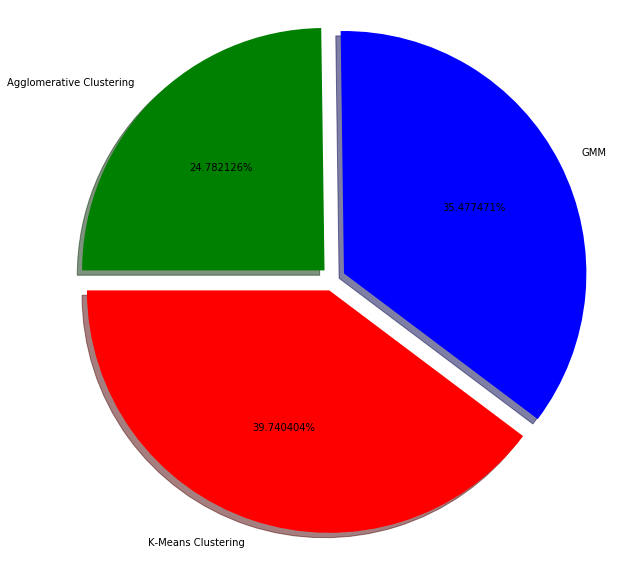

In [30]:
labels = 'K-Means Clustering', 'GMM', 'Agglomerative Clustering'
input_list = [purity,avg_purity,average_agg]
colors = ['red','blue','green']
explode = (0.05, 0.05, 0.05)
 
plt.figure(figsize=(10,10))
plt.pie(input_list, explode=explode, labels=labels, colors=colors,
autopct='%f%%', shadow=True, startangle=180)
 
plt.axis('equal')
plt.show()


------------------------------------------------------------
<h1>Question 2

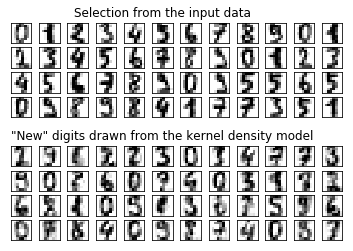

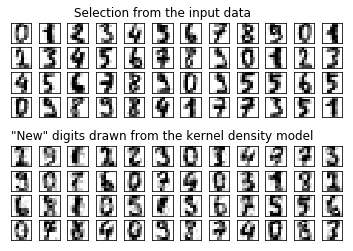

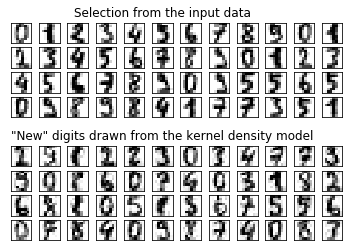

In [56]:
digits = load_digits()

# project the 64-dimensional data to a lower dimension
a = [20,30,40]

for i in a:
    pca = PCA(n_components=i, whiten=False)
    data = pca.fit_transform(digits.data)

    # use grid search cross-validation to optimize the bandwidth
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(data)

    # use the best estimator to compute the kernel density estimate
    kde = grid.best_estimator_

    # sample 44 new points from the data
    new_data = kde.sample(48, random_state=0)
    new_data = pca.inverse_transform(new_data)

    # turn data into a 4x12 grid
    new_data = new_data.reshape((4, 12, -1))
    real_data = digits.data[:48].reshape((4, 12, -1))

    # plot real digits and resampled digits
    fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]))
    for j in range(12):
        ax[4, j].set_visible(False)
        for i in range(4):
            im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)
            im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)

    ax[0, 5].set_title('Selection from the input data')
    ax[5, 5].set_title('"New" digits drawn from the kernel density model')

    plt.show()

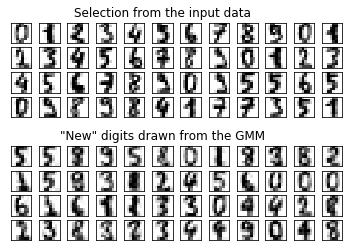

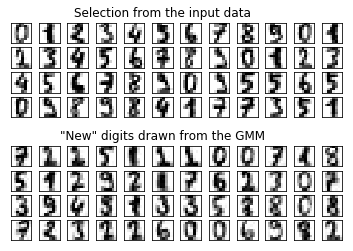

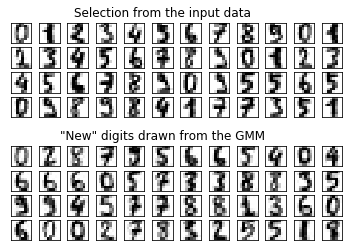

In [58]:
for i in a:
    pca = PCA(n_components=i, whiten=False)
    data = pca.fit_transform(digits.data)

    components = np.arange(50, 400, 20)
    models = [GMM(n, covariance_type='full', random_state=0)
              for n in components]
    aics = [model.fit(data).aic(data) for model in models]
    GMM_Comp = components[np.argmin(aics)]
    
    gmm = GMM(GMM_Comp, covariance_type='full', random_state=0)
    gmm.fit(data)
    
    data_new = gmm.sample(48)
    digits_new = pca.inverse_transform(data_new[0]).reshape((4, 12, -1))
    real_data  = digits.data[:48].reshape((4, 12, -1))

    fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]))
    for j in range(12):
        ax[4, j].set_visible(False)
        for i in range(4):
            im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)
            im = ax[i + 5, j].imshow(digits_new[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
            im.set_clim(0, 16)

    ax[0, 5].set_title('Selection from the input data')
    ax[5, 5].set_title('"New" digits drawn from the GMM')

    plt.show()


<h3> References </h3>

https://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
